# Install & Import Libraries

In [135]:
import os
import glob
import numpy as np
import pandas as pd
import time
import random
import tensorflow as tf
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from sklearn.utils.class_weight import compute_class_weight

# Parameters

In [137]:
sampling_rate = 20
window_size = 3 * sampling_rate  # 60 timesteps
wand_classes = ["Circle", "Infinity", "None", "Square", "Triangle", "Wave", "Zigzag"]
num_channels_online = 45
num_channels_wand = 6
batch_size = 16
epochs = 30
weight_decay = 1e-4

# Processing Functions

In [139]:
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff=5, fs=50, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return lfilter(b, a, data)

def normalize_window(window):
    return (window - np.mean(window, axis=0)) / (np.std(window, axis=0) + 1e-8)

def pad_or_crop(sample, window_size):
    n_rows, n_cols = sample.shape
    if n_rows > window_size:
        return sample[:window_size, :]
    elif n_rows < window_size:
        pad_width = ((0, window_size - n_rows), (0, 0))
        return np.pad(sample, pad_width, mode='constant')
    else:
        return sample

# Dataset loader

In [141]:
def load_preprocess_dataset(dataset_path, window_size=60, 
                                   selected_channels=None, class_list=None, use_labels_folder=True):
    """Load dataset and apply global normalization."""
    data_folder = os.path.join(dataset_path, "data_clean")
    X_list, y_list = [], []

    data_files = sorted(os.listdir(data_folder))

    if use_labels_folder:
        label_folder = os.path.join(dataset_path, "label")
        label_files = sorted(os.listdir(label_folder))
        for data_file, label_file in zip(data_files, label_files):
            arr = pd.read_csv(os.path.join(data_folder, data_file)).values
            if selected_channels:
                arr = arr[:, selected_channels]
            arr = pad_or_crop(arr, window_size)
            X_list.append(arr)

            with open(os.path.join(label_folder, label_file), 'r') as f:
                y_list.append(f.read().strip())
    else:
        for data_file in data_files:
            arr = pd.read_csv(os.path.join(data_folder, data_file)).values
            if selected_channels:
                arr = arr[:, selected_channels]
            arr = pad_or_crop(arr, window_size)
            X_list.append(arr)

            # Infer label from filename
            label = os.path.splitext(data_file)[0].split("_")[0].capitalize()
            y_list.append(label)

    X_stack = np.stack(X_list, axis=0)
    y = np.array(y_list)

    # Compute global mean/std over all windows
    all_data = X_stack.reshape(-1, X_stack.shape[2])
    channel_mean = all_data.mean(axis=0)
    channel_std = all_data.std(axis=0)
    channel_std[channel_std < 1e-6] = 1.0

    # Apply global normalization
    X_norm = (X_stack - channel_mean) / channel_std

    # Encode labels
    encoder = LabelEncoder()
    if class_list:
        encoder.fit(class_list)
    else:
        encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_onehot = np.eye(len(encoder.classes_))[y_encoded]

    print(f"Loaded {len(X_norm)} samples, {X_norm.shape[1]} timesteps, {X_norm.shape[2]} channels")
    print(f"Classes: {list(encoder.classes_)}")

    return X_norm, y_onehot, encoder, channel_mean, channel_std


# Train base model on online dataset

In [143]:
dataset_online_path = r"C:\Users\CK Cheong\Desktop\rosbag\data"
X_online, y_online, encoder_online, mean_online, std_online = load_preprocess_dataset(
    dataset_online_path,
    window_size=window_size,
    selected_channels=None,
    class_list=None,
    use_labels_folder=True
)

# Split for training/validation
X_train_online, X_val_online, y_train_online, y_val_online = train_test_split(
    X_online, y_online, test_size=0.2, stratify=y_online, random_state=42
)

Loaded 810 samples, 60 timesteps, 45 channels
Classes: ['label\n0', 'label\n1', 'label\n10', 'label\n2', 'label\n3', 'label\n4', 'label\n5', 'label\n6']


# Base CNN Model

In [145]:
base_model = Sequential([
    tf.keras.Input(shape=(window_size, num_channels_online)),
    
    Conv1D(32, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),
    
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(0.4),
    Dense(len(encoder_online.classes_), activation='softmax')
])

base_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

history_online = base_model.fit(
    X_train_online, y_train_online,
    validation_data=(X_val_online, y_val_online),
    epochs=30,
    batch_size=32
)

# Save base model
base_model.save("base_model_online.keras")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 56, 32)         │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 24, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,912 (202.78 KB)

 Trainable params: 51,464 (201.03 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.2886 - loss: 1.9840 - val_accuracy: 0.4321 - val_loss: 1.7429
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5108 - loss: 1.3171 - val_accuracy: 0.6605 - val_loss: 1.4785
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6204 - loss: 1.0436 - val_accuracy: 0.7160 - val_loss: 1.2470
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6852 - loss: 0.8943 - val_accuracy: 0.7407 - val_loss: 1.0559
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7052 - loss: 0.8410 - val_accuracy: 0.7840 - val_loss: 0.8851
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7500 - loss: 0.6967 - val_accuracy: 0.7901 - val_loss: 0.7439
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7654 - loss: 0.6660 - val_accuracy: 0.7654 - val_loss: 0.6724
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7731 - loss: 0.5872 - val_accuracy: 0.8148 - 

# Clean wand dataset and load

In [147]:
wand_dataset = r"C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset"

X_wand, y_wand, encoder_wand, mean_wand, std_wand = load_preprocess_dataset(
    wand_dataset,
    window_size=window_size,
    selected_channels=[0,1,2,3,4,5],
    class_list=wand_classes,
    use_labels_folder=False
)

Loaded 4130 samples, 60 timesteps, 6 channels
Classes: ['Circle', 'Infinity', 'None', 'Square', 'Triangle', 'Wave', 'Zigzag']


# Compute mean, std

In [149]:
# Split train/val 
X_train, X_val, y_train, y_val = train_test_split(
    X_wand, y_wand, test_size=0.2, stratify=y_wand, random_state=42
)

# Save the mean and std values to .npy (from loader)
np.save("mean_std.npy", {"mean": mean_wand, "std": std_wand})

data = np.load("mean_std.npy", allow_pickle=True).item()
mean = data["mean"]
std  = data["std"]

with open("mean_std.h", "w") as f:
    f.write("#ifndef MEAN_STD_H\n#define MEAN_STD_H\n\n")
    f.write("#include <cstdint>\n\n")

    f.write(f"const float channel_mean[{len(mean)}] = {{")
    f.write(", ".join(f"{m:.8f}" for m in mean))
    f.write("};\n")

    f.write(f"const float channel_std[{len(std)}] = {{")
    f.write(", ".join(f"{s:.8f}" for s in std))
    f.write("};\n\n")

    f.write("#endif // MEAN_STD_H\n")

print("mean_std.h generated successfully.")

mean_std.h generated successfully.


# Apply augmentation

In [151]:
def augment_window_tf(window, label):
    # Ensure window is float32
    window = tf.cast(window, tf.float32)  
    # Gaussian noise
    noise = tf.random.normal(shape=tf.shape(window), mean=0.0, stddev=0.01, dtype=tf.float32)
    # Random scale factor
    scale = tf.random.uniform([], 0.9, 1.1, dtype=tf.float32)
    # Random time shift
    shift = tf.random.uniform([], -3, 3, dtype=tf.int32)
    # Apply augmentations
    window = window + noise
    window = window * scale
    window = tf.roll(window, shift=shift, axis=0)
    
    return window, label

def make_dataset(X, y, batch_size=32, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), reshuffle_each_iteration=True)
        ds = ds.map(augment_window_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=16, training=True)
val_ds   = make_dataset(X_val, y_val, batch_size=16, training=False)

# Compute Class Weights (for balancing) 
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Define Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "cnn_finetuned_wand_best.keras", monitor='val_accuracy',
    save_best_only=True, verbose=1
)

Class Weights: {0: 0.9978858350951374, 1: 1.0107066381156318, 2: 0.9915966386554622, 3: 1.0107066381156318, 4: 1.0107066381156318, 5: 0.9874476987447699, 6: 0.9915966386554622}


# Fine-tune model for wand dataset

In [153]:
finetune_model = Sequential([
    tf.keras.Input(shape=(window_size, num_channels_wand)),

    Conv1D(32, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(0.4),
    Dense(len(encoder_wand.classes_), activation='softmax')
])

finetune_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

finetune_model.summary()

# Train Model 
history_finetune = finetune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Save Final Model 
finetune_model.save("cnn_finetuned_wand_augmented.keras")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 56, 32)         │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 24, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,295 (63.65 KB)

 Trainable params: 16,103 (62.90 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1711 - loss: 2.1133
Epoch 1: val_accuracy improved from None to 0.42615, saving model to cnn_finetuned_wand_best.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2237 - loss: 1.9951 - val_accuracy: 0.4262 - val_loss: 1.7697
Epoch 2/50
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3406 - loss: 1.7676
Epoch 2: val_accuracy improved from 0.42615 to 0.53148, saving model to cnn_finetuned_wand_best.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3541 - loss: 1.7344 - val_accuracy: 0.5315 - val_loss: 1.5416
Epoch 3/50
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3868 - loss: 1.6249
Epoch 3: val_accuracy improved from 0.53148 to 0.63438, saving model to cnn_finetuned_wand_best.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4128 - loss: 1.5903 - val_accuracy: 0.6344 - val_loss: 1.3983
Epoch 4/50
205/207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4383 - loss: 1

# Evaluate fine-tuned model

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

      Circle       0.97      0.82      0.89       591
    Infinity       0.88      0.99      0.93       584
        None       0.92      0.95      0.93       595
      Square       0.89      0.98      0.94       584
    Triangle       0.96      0.87      0.92       583
        Wave       0.95      0.94      0.94       598
      Zigzag       0.97      0.96      0.97       595

    accuracy                           0.93      4130
   macro avg       0.93      0.93      0.93      4130
weighted avg       0.94      0.93      0.93      4130



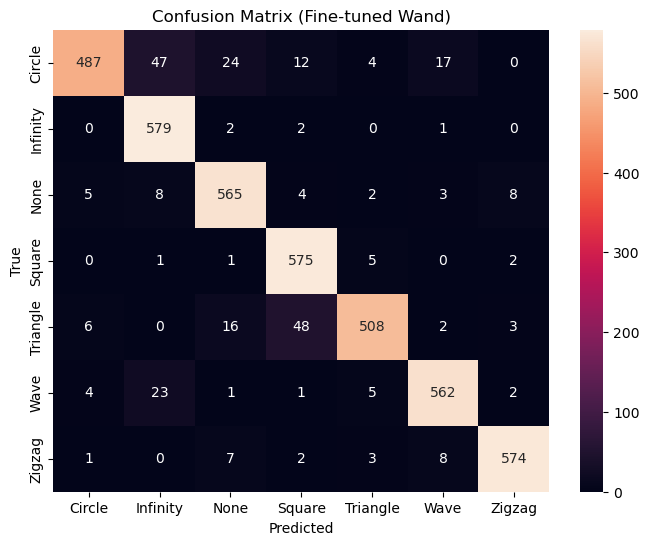

In [155]:
y_pred = finetune_model.predict(X_wand)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_wand, axis=1)

print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=wand_classes,
    zero_division=0
))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=wand_classes, yticklabels=wand_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Fine-tuned Wand)')
plt.show()


# Generate test data and Extract Weights, Biases

In [157]:
# Load your trained model
model = tf.keras.models.load_model("cnn_finetuned_wand_augmented.keras")

# Parameters
num_samples = 10
window_size = 60
num_channels_wand = 6
num_classes = 7
clean_dir = r"C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset\data_clean"

# Load and preprocess test windows
def load_test_windows(num_samples=num_samples):
    files = sorted(glob.glob(os.path.join(clean_dir, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {clean_dir}")

    # Group files by class
    class_to_files = {}
    for f in files:
        label = os.path.basename(f).split("_")[0].capitalize()
        class_to_files.setdefault(label, []).append(f)

    class_names = list(class_to_files.keys())
    num_classes_found = len(class_names)
    print(f"Found {num_classes_found} classes:", class_names)

    if num_classes_found == 0:
        raise ValueError("No classes found in directory")

    # Ensure at least one per class (if possible)
    samples_per_class = {cls: 1 for cls in class_names}
    remaining = num_samples - num_classes_found

    # Distribute remaining samples proportionally to number of available files
    total_files = sum(len(v) for v in class_to_files.values())
    for cls in class_names:
        if remaining <= 0:
            break
        cls_fraction = len(class_to_files[cls]) / total_files
        add = int(round(cls_fraction * remaining))
        samples_per_class[cls] += add

    # Adjust if rounding causes overflow/underflow
    total_assigned = sum(samples_per_class.values())
    while total_assigned > num_samples:
        reducible = [c for c, n in samples_per_class.items() if n > 1]
        if not reducible:
            break
        cls = random.choice(reducible)
        samples_per_class[cls] -= 1
        total_assigned -= 1

    while total_assigned < num_samples:
        cls = random.choice(class_names)
        samples_per_class[cls] += 1
        total_assigned += 1

    X, labels = [], []

    # Sample and preprocess
    for cls, n_samples in samples_per_class.items():
        class_files = class_to_files[cls]
        random.shuffle(class_files)
        chosen_files = class_files[:n_samples]

        for f in chosen_files:
            df = pd.read_csv(f)
            arr = df.values.astype(np.float32)

            # Adjust number of channels
            if arr.shape[1] != num_channels_wand:
                if arr.shape[1] > num_channels_wand:
                    arr = arr[:, -num_channels_wand:]
                else:
                    print("Skipping (wrong #cols):", f)
                    continue

            # Pad or crop to window size
            if arr.shape[0] > window_size:
                arr = arr[:window_size, :]
            elif arr.shape[0] < window_size:
                pad = np.zeros((window_size - arr.shape[0], arr.shape[1]), dtype=np.float32)
                arr = np.vstack([arr, pad])

            arr = (arr - mean_wand) / std_wand

            X.append(arr)
            labels.append(cls)

    X = np.stack(X, axis=0)
    return X, labels, class_names

x_test, y_labels, class_names = load_test_windows(num_samples)

# 2. Predict
y_pred = model.predict(x_test, verbose=0)
pred_classes = np.argmax(y_pred, axis=1)

print("Predicted classes:", pred_classes)
print("True labels:", y_labels)

# 3. Quantization
def quantize_q8_8(x):
    return np.round(x * 256).astype(np.int16)

x_q = quantize_q8_8(x_test)       # Q8.8 input
y_q = quantize_q8_8(y_pred)       # Q8.8 output

# Write test_data.h
with open("test_data.h", "w") as f:
    f.write("/* Test dataset from Keras CNN */\n")
    f.write("#ifndef TEST_DATA_H\n#define TEST_DATA_H\n\n")
    f.write("#include <cstdint>\n\n")
    f.write(f"#define NUM_SAMPLES {x_q.shape[0]}\n")
    f.write(f"#define INPUT_LEN {window_size}\n")
    f.write(f"#define INPUT_CH {num_channels_wand}\n")
    f.write(f"#define NUM_CLASSES {num_classes}\n\n")

    # Input array
    f.write(f"const int16_t test_inputs[NUM_SAMPLES][INPUT_LEN][INPUT_CH] = {{\n")
    for n in range(x_q.shape[0]):
        f.write("  {\n")
        for t in range(window_size):
            row = ", ".join(map(str, x_q[n, t]))
            f.write(f"    {{{row}}},\n")
        f.write("  },\n")
    f.write("};\n\n")

    # Output array
    f.write(f"const int16_t test_outputs[NUM_SAMPLES][NUM_CLASSES] = {{\n")
    for n in range(x_q.shape[0]):
        row = ", ".join(map(str, y_q[n]))
        f.write(f"  {{{row}}},\n")
    f.write("};\n\n")
    f.write("#endif // TEST_DATA_H\n")

# Export weights
def quantize_bias(b):
    return np.round(b * (256 * 256)).astype(np.int32)

with open("cnn_weights.h", "w") as f:
    f.write("// CNN weights (Q8.8 fixed-point)\n\n")
    f.write("#include <cstdint>\n\n")
    for layer in model.layers:
        weights = layer.get_weights()
        if not weights:
            continue
        f.write(f"// Layer: {layer.name}\n")
        for i, w in enumerate(weights):
            if len(w.shape) == 3:  # Conv1D
                w = np.transpose(w, (2, 1, 0))  # (out, in, k)
                q = quantize_q8_8(w)
            elif len(w.shape) == 2:  # Dense
                q = quantize_q8_8(w)
            elif len(w.shape) == 1:  # Bias
                q = quantize_bias(w)
            else:
                continue
            flat = q.flatten()
            dtype = "int32_t" if len(w.shape) == 1 else "int16_t"
            name = f"{layer.name}_param{i}"
            f.write(f"const {dtype} {name}[{len(flat)}] = {{\n")
            f.write(", ".join(map(str, flat)))
            f.write("\n};\n\n")
    f.write("// End of cnn_weights.h\n")

print("Test data and weights exported.")

Found 7 classes: ['Circle', 'Infinity', 'None', 'Square', 'Triangle', 'Wave', 'Zigzag']
Predicted classes: [0 1 1 2 3 4 4 5 5 6]
True labels: ['Circle', 'Infinity', 'Infinity', 'None', 'Square', 'Triangle', 'Triangle', 'Wave', 'Wave', 'Zigzag']
Test data and weights exported.
